In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn import metrics
# import plots
import seaborn as sns
from datetime import datetime

import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)

In [2]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files'


country = 'Mexico'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'

### Merge FB pop grid with baseline_pop reported data via merge on 'FID'

In [3]:
grid_pop = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_pop/Grid_' + country + '.shp').to_crs('EPSG:4326')
baseline_pop = pd.read_csv(wd + '/data/outputs/' + country_short + '/baseline/baseline_pop.csv')
baseline_pop = baseline_pop.fillna(-1)
baseline_pop = baseline_pop.replace(-999, -1)

grid_pop = pd.merge(grid_pop, baseline_pop, on='FID', how='left')


/Users/carmen/anaconda3/envs/geo-env-new/lib/python3.11/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

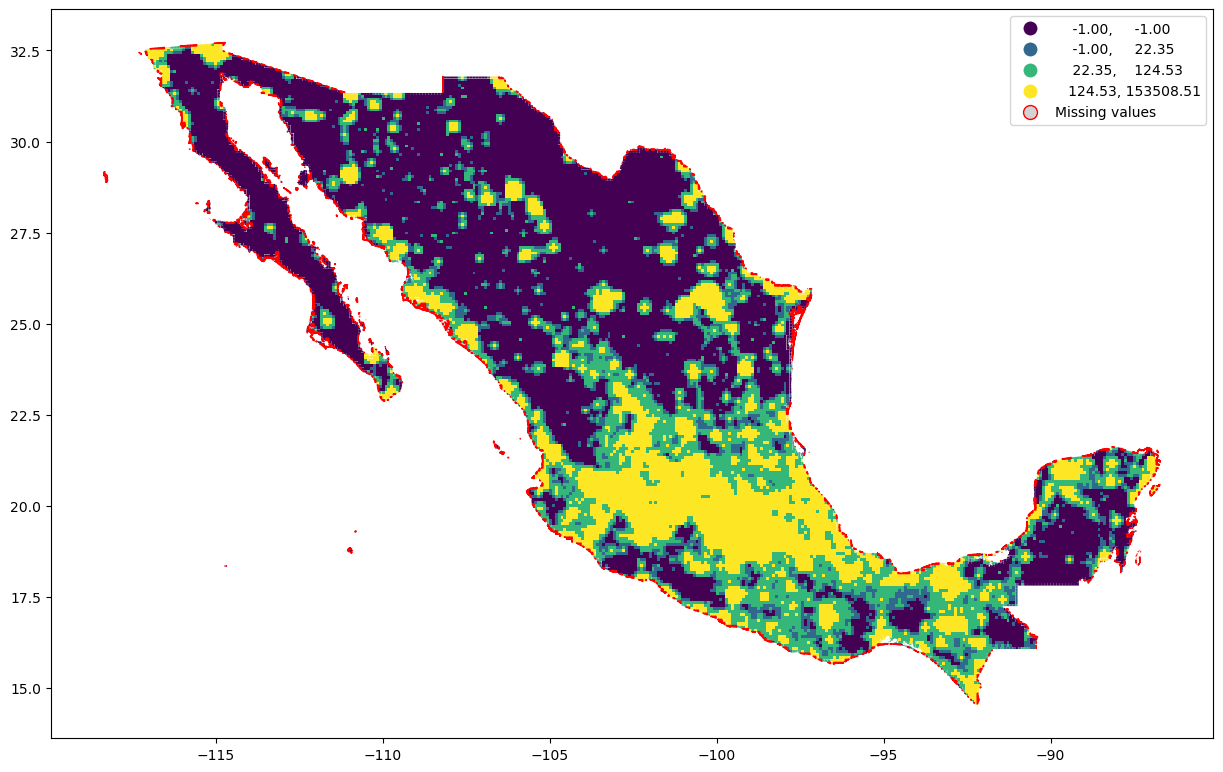

In [4]:
grid_pop.plot(column='0', legend=True,
    scheme="quantiles",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)

In [5]:
np.sqrt(grid_pop.to_crs('epsg:3857').loc[10, 'geometry'].area)/1000

9.783936925651389

### Merge popcell with FB pop data with WP population via spatial join

In [6]:
# Import worldpop raster and turn it into geodataframe of points based on centroids of pixels
rds = rx.open_rasterio(wd + '/data/inputs/population/worldpop/' + country_short.lower() + '_ppp_2020_1km_Aggregated.tif')
rds.name = "population"

df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
gdf_worldpop = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

gdf_worldpop = gdf_worldpop.drop(['y', 'x', 'band', 'spatial_ref'], axis = 1)

In [7]:
# Drop geometries from gdf_worldpop where the population value is not well-defined
gdf_worldpop = gdf_worldpop[gdf_worldpop['population'] != -99999].reset_index(drop=True)
gdf_worldpop = gdf_worldpop.to_crs('EPSG:4326')

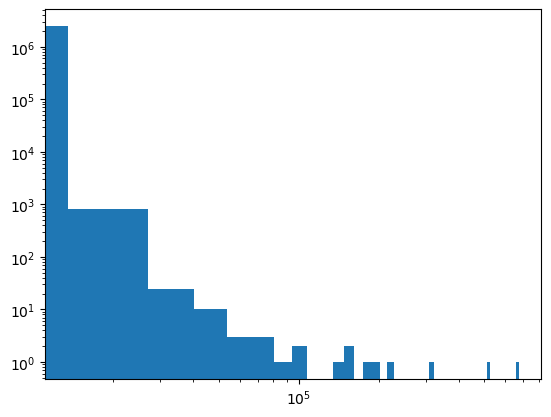

In [8]:
fig, ax = plt.subplots()
plt.hist(gdf_worldpop['population'], bins=50)
ax.set_xscale('log')
ax.set_yscale('log')

In [9]:
# Spatial join of worldpop geometries with grid - CAUTION: it drops grid cells with no data, but this can be fixed later
grid_wp = gpd.sjoin(grid_pop, gdf_worldpop)

# Regroup joined data so that there is only one entry per grid cell 
# (i.e. sum the population corresponding to raster pixels whose centroid falls within the same grid cell)
grid_wp_group = grid_wp.drop(['geometry', 'index_right'] + [str(i) for i in range(7)], axis=1)
grid_wp_group = grid_wp_group.groupby(['FID']).sum()

# Some data wrangling to obtain gdf_mmerge, which is a final geodataframe with one entry for each original grid cell in grid
# with a column for the total population of that grid (based on spatial join with the raster data)
gdf_merge = pd.merge(grid_wp, grid_wp_group, on = 'FID')
gdf_merge = gdf_merge.drop(['index_right', 'population_x', 'geometry'] + [str(i) for i in range(7)], axis=1)
gdf_merge = gdf_merge.drop_duplicates()
gdf_merge.reset_index(drop=True)

gdf_mmerge = pd.merge(grid_pop, gdf_merge, how='left', on='FID')
gdf_mmerge = gdf_mmerge.rename({'population_y': 'pop_wp'}, axis=1)
gdf_mmerge = gpd.GeoDataFrame(gdf_mmerge, geometry='geometry')

grid_pop = gdf_mmerge

if country == 'Mexico':
    id_max = grid_pop[grid_pop['pop_wp'] == max(grid_pop['pop_wp'])].index[0]
    w = weights.Queen.from_dataframe(grid_pop, idVariable="FID")
    grid_pop_w = grid_pop.drop(w.islands)
    w = weights.Queen.from_dataframe(grid_pop_w, idVariable="FID")
    w.transform = 'R'
    grid_pop_w['pop_wp_lag'] = weights.lag_spatial(w, grid_pop_w['pop_wp'])
    grid_pop.loc[id_max, 'pop_wp'] = grid_pop_w[grid_pop_w['FID'] == id_max]['pop_wp_lag'].iloc[0]

/var/folders/_n/krcxvsq92k7bdd1nfpk3_9c00000gn/T/ipykernel_52299/106684813.py:24: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(grid_pop, idVariable="FID")
/Users/carmen/anaconda3/envs/geo-env-new/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 47 disconnected components.
 There are 25 islands with ids: 624, 4166, 4469, 4470, 5170, 8620, 8959, 8981, 8982, 9193, 9286, 13919, 13938, 14080, 14220, 14959, 15112, 16708, 17434, 19102, 19271, 20744, 20896, 22747, 23110.
  W.__init__(self, neighbors, ids=ids, **kw)
/var/folders/_n/krcxvsq92k7bdd1nfpk3_9c00000gn/T/ipykernel_52299/106684813.py:26: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(grid_pop_w, idVariable="FID")
/Users/carmen/anaconda3/envs/geo-env-new/lib/python3.11/site-packages/libpysal/wei

<Axes: >

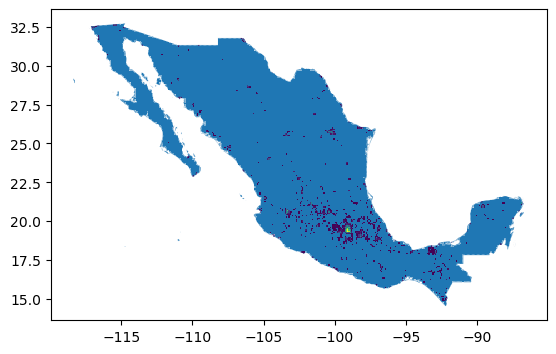

In [10]:
fig, ax = plt.subplots()
grid_pop.sort_values(by=['pop_wp'], ascending=False).iloc[0:1000].plot(column='pop_wp', ax=ax, zorder=2)
grid_pop.sort_values(by=['pop_wp'], ascending=False).plot(ax=ax, zorder=1)
# ax.set_xlim([-105,-95])
# ax.set_ylim([23,27.5])

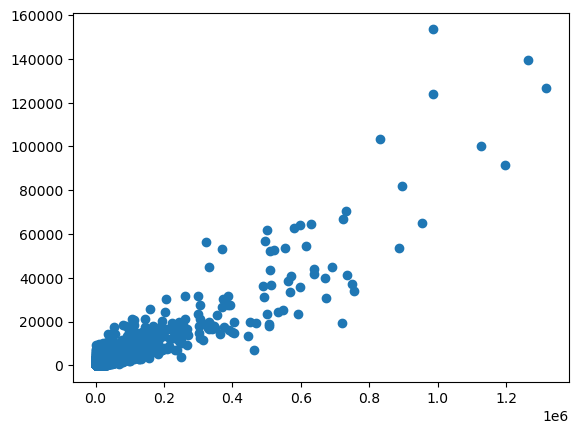

In [11]:
plt.scatter(grid_pop['pop_wp'], grid_pop['0'])

In [12]:
len(grid_pop[pd.isna(grid_pop['pop_wp'])])/len(grid_pop)*100

0.5861709922486599

### Test correlations of WP data with recorded observations for each day of the week
The test is to see if it makes sense to estimate missing baseline data with the WP population

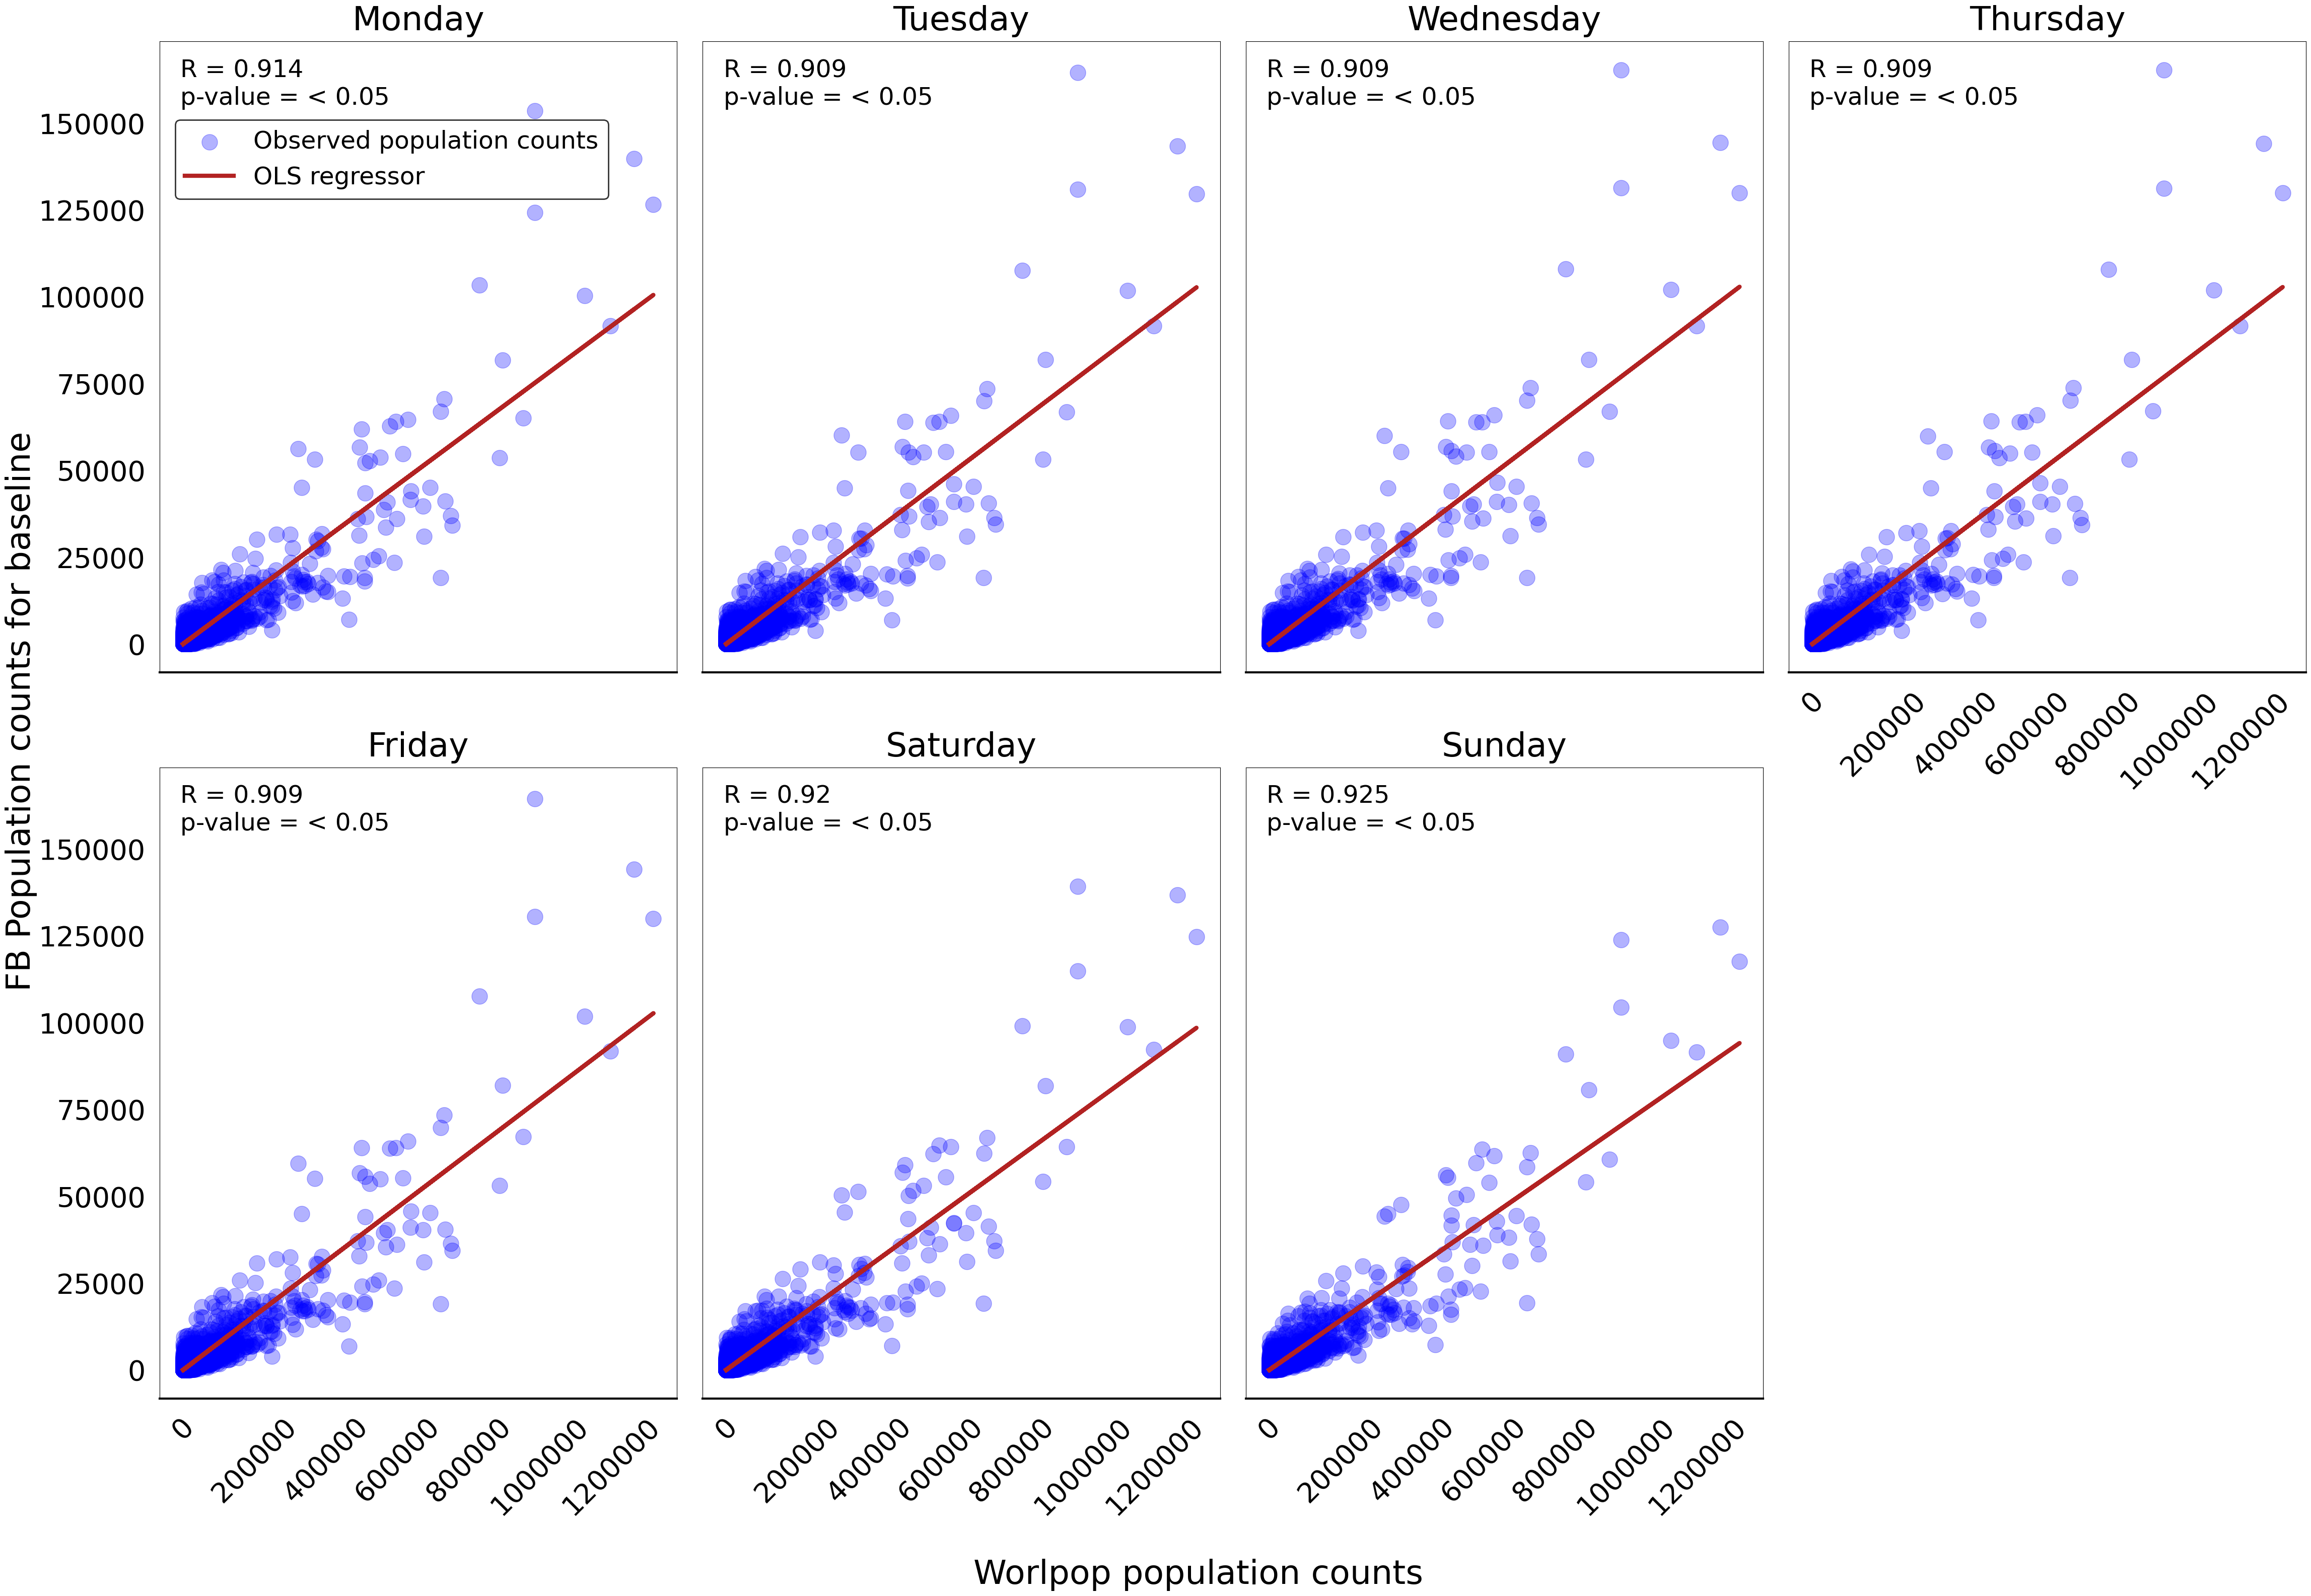

In [14]:
nrows=2
ncols=4
fig, axes = plt.subplots(nrows= nrows, ncols = ncols, sharex = True, sharey = True, figsize = (55, 35))
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(wspace=0.05)
ax = axes.flatten()

wday = str(0)
for i, ax in enumerate(axes.flat):
        
    try:

        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

        ax.spines['bottom'].set_linewidth(3)
        
        grid_pop_plot = grid_pop.copy()
        grid_pop_plot = grid_pop_plot.dropna(subset=['pop_wp']).reset_index(drop=True)
        grid_pop_plot = grid_pop_plot.dropna(subset=[str(wday)]).reset_index(drop=True)
        grid_pop_plot = grid_pop_plot[grid_pop_plot[str(wday)] > 0]
        grid_pop_plot = grid_pop_plot.sort_values(by=['pop_wp']).reset_index(drop=True)
        
#         if country == 'Mexico':
#             grid_pop_plot = grid_pop_plot[grid_pop_plot['pop_wp'] < max(grid_pop_plot['pop_wp'])].reset_index(drop=True)

        ax.scatter(grid_pop_plot['pop_wp'], grid_pop_plot[str(wday)], color='blue', marker="o", label="Observed population counts", 
                   zorder=2, alpha=0.3, s=500)
        
        
        xticks = [0]
        upper = 0
        while upper < ax.get_xlim()[1] - 200000:
            upper += 200000
            xticks.append(upper)

        ax.set_xticks(xticks) 
        ax.set_xticklabels(xticks, y = 0, rotation = 45, color = 'k')
        ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize = 40, pad=20)
        
        #Regressions
        grid_pop_dropna = grid_pop.copy()
        grid_pop_dropna = grid_pop_dropna.dropna()
        grid_pop_dropna = grid_pop_dropna.sort_values(by=['pop_wp'])
#         if country == 'Mexico':
#             grid_pop_dropna = grid_pop_dropna[grid_pop_dropna['pop_wp'] < max(grid_pop_dropna['pop_wp'])].reset_index(drop=True)

        
        x_predict = grid_pop['pop_wp']

        #OLS
        df = pd.DataFrame({'pop_wp': grid_pop_dropna['pop_wp'], 'pop_FB': grid_pop_dropna[str(wday)]})
        res = smf.ols('pop_FB ~ pop_wp - 1', data=df).fit()
        st, data, ss2 = summary_table(res, alpha=0.05)
        y_predict = res.predict(x_predict)
        predict_mean_se  = data[:, 3]
        predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
        predict_ci_low, predict_ci_upp = data[:, 6:8].T
        #Plot
        ax.plot(x_predict, y_predict, color="firebrick", linestyle="-", label="OLS regressor", lw=6, zorder=3)
#         ax.plot(df['pop_wp'], predict_ci_upp, color="firebrick", linestyle="-", label='OLS Prediction interval (95%)', zorder=3)
#         ax.plot(df['pop_wp'], predict_ci_low, color="firebrick", linestyle="-", zorder=3)
        
#         #RANSAC
#         X = np.array(grid_pop_plot['pop_wp'])
#         y = np.array(grid_pop_plot[str(wday)])
#         # Robustly fit linear model with RANSAC algorithm
#         ransac = linear_model.RANSACRegressor(random_state=62)
#         ransac.fit(X.reshape(-1, 1), y)
#         inlier_mask = ransac.inlier_mask_
#         outlier_mask = np.logical_not(inlier_mask)
#         # Predict data of estimated models
#         y_predict = ransac.predict(np.array(x_predict)).reshape(-1,1)
#         #Plot
#         ax.plot(x_predict, y_predict, color="firebrick", linestyle="-", label="RANSAC regressor", lw=6, zorder=3)
        
        pearson = scipy.stats.pearsonr(df['pop_wp'], df['pop_FB'])
        R = str(round(pearson.statistic,3))
        pvalue = str(round(pearson.pvalue,2))
        if float(pvalue) < 0.05:
            pvalue = '< 0.05'
        ax.text(0.04, 0.9, 'R = ' + R + '\np-value = ' + pvalue, transform=ax.transAxes, size=35)

        if wday == '0':
            title = 'Monday'
        elif wday == '1':
            title = 'Tuesday'
        elif wday == '2':
            title = 'Wednesday'
        elif wday == '3':
            title = 'Thursday'
        elif wday == '4':
            title = 'Friday'
        elif wday == '5':
            title = 'Saturday'
        elif wday == '6':
            title = 'Sunday'
        ax.set_title(title, size=48, pad=16)

        grid_pop[str(wday) + '_imput'] = y_predict
#         grid_pop_dropna = grid_pop_dropna[['FID', str(wday) + '_imput']]
#         grid_pop = pd.merge(grid_pop, grid_pop_dropna, how='left')



#         ax.set_xscale('log')
#         ax.set_yscale('log')
        
        wday = str(int(wday) + 1)

    except:
        break

legend = axes[0,0].legend(loc=(0.03, 0.75), fontsize=35)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

# for matplotlib version 2.1.1
axes[0,3].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False)
fig.delaxes(axes.flat[-1])

# Set common labels
fig.text(0.5, 0.01, 'Worlpop population counts', ha='center', va='center', size=48)
fig.text(0.075, 0.5, 'FB Population counts for baseline', ha='center', va='center', rotation='vertical', size=48)

# plt.savefig(wd + '/plots/correlation-wp-fb-pop-baseline/correlation-wp-fb-pop-baseline-' + country_short + '.pdf', bbox_inches = 'tight')


plt.show()


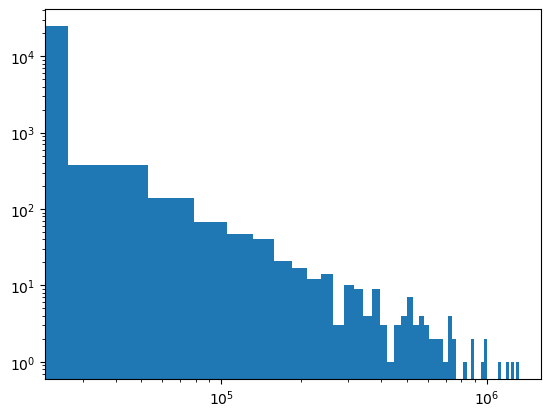

In [15]:
fig, ax = plt.subplots()
plt.hist(grid_pop['pop_wp'], bins=50)
ax.set_xscale('log')
ax.set_yscale('log')

In [16]:
grid_pop[grid_pop['pop_wp'] == max(grid_pop['pop_wp'])]['geometry'].centroid

/var/folders/_n/krcxvsq92k7bdd1nfpk3_9c00000gn/T/ipykernel_52299/2131389947.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_pop[grid_pop['pop_wp'] == max(grid_pop['pop_wp'])]['geometry'].centroid


5380    POINT (-99.09668 19.35260)
dtype: geometry

In [17]:
print(len(grid_pop), len(grid_pop_dropna))

25931 24766


In [18]:
grid_pop_imput = grid_pop.copy()

wday = [str(i) for i in range(7)]
for i in range(len(grid_pop_imput)):
    for j in wday:
        if grid_pop_imput.loc[i, j] == -1 or pd.isna(grid_pop_imput.loc[i, j]) == True:
            grid_pop_imput.loc[i, j] = grid_pop_imput.loc[i, j + '_imput']

grid_pop_imput = grid_pop_imput.drop([str(i) + '_imput' for i in range(7)], axis=1)
grid_pop_imput.to_file(wd + '/data/outputs/' + country_short + '/grids-with-data/popcell-baseline-imput-pop/popcell-baseline-imput-pop.gpkg')
grid_pop_imput


,FID,geometry,0,1,2,3,4,5,6,pop_wp
0,0,"POLYGON ((-92.28516 14.60484, -92.28516 14.587...",1.789244,1.827987,1.831134,1.829704,1.828568,1.753881,1.675756,23.459784
1,1,"POLYGON ((-92.28516 14.60484, -92.19727 14.604...",185.126274,185.157403,185.903621,185.255030,185.864361,183.093071,176.590457,3269.556885
2,2,"POLYGON ((-92.19727 14.60484, -92.17801 14.604...",484.303790,494.790356,495.642133,495.255086,494.947562,474.731868,453.585327,6349.977539
3,3,"POLYGON ((-92.37305 14.68988, -92.37305 14.667...",37.874741,38.694838,38.761451,38.731182,38.707132,37.126174,35.472419,496.596893
4,4,"POLYGON ((-92.37305 14.68988, -92.28516 14.689...",111.135735,110.860484,111.077817,110.630554,109.784782,108.153335,111.867716,4041.785156
...,...,...,...,...,...,...,...,...,...,...
25926,25926,"POLYGON ((-115.04883 32.69486, -115.05241 32.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25927,25927,"POLYGON ((-114.96094 32.69486, -115.04883 32.6...",0.141261,0.144319,0.144568,0.144455,0.144365,0.138469,0.132301,1.852146
25928,25928,"POLYGON ((-114.87305 32.69486, -114.96094 32.6...",2.865770,2.927822,2.932862,2.930572,2.928752,2.809130,2.683999,37.574707
25929,25929,"POLYGON ((-114.78516 32.69486, -114.87305 32.6...",2.113655,2.159422,2.163139,2.161450,2.160108,2.071880,1.979590,27.713316


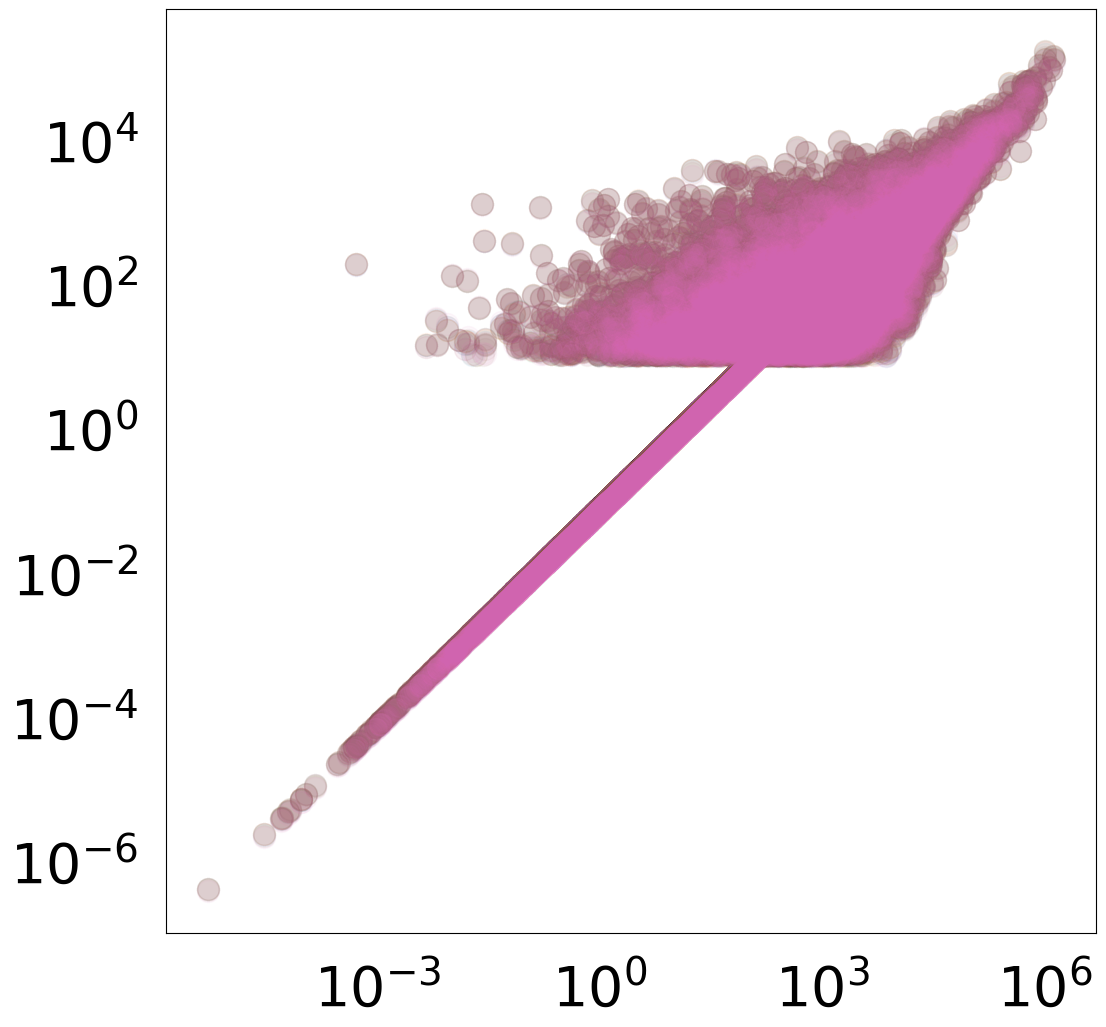

In [19]:
fig,ax = plt.subplots(figsize=(12,12))

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize = 40, pad=20)

grid_pop_imput_sort = grid_pop_imput.sort_values(by=['pop_wp'])
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['0'], alpha=0.05, s=250)
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['1'], alpha=0.05, s=250)
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['2'], alpha=0.05, s=250)
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['3'], alpha=0.05, s=250)
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['4'], alpha=0.05, s=250)
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['5'], alpha=0.05, s=250)
ax.scatter(grid_pop_imput_sort['pop_wp'], grid_pop_imput_sort['6'], alpha=0.05, s=250)
ax.set_xscale('log')
ax.set_yscale('log')

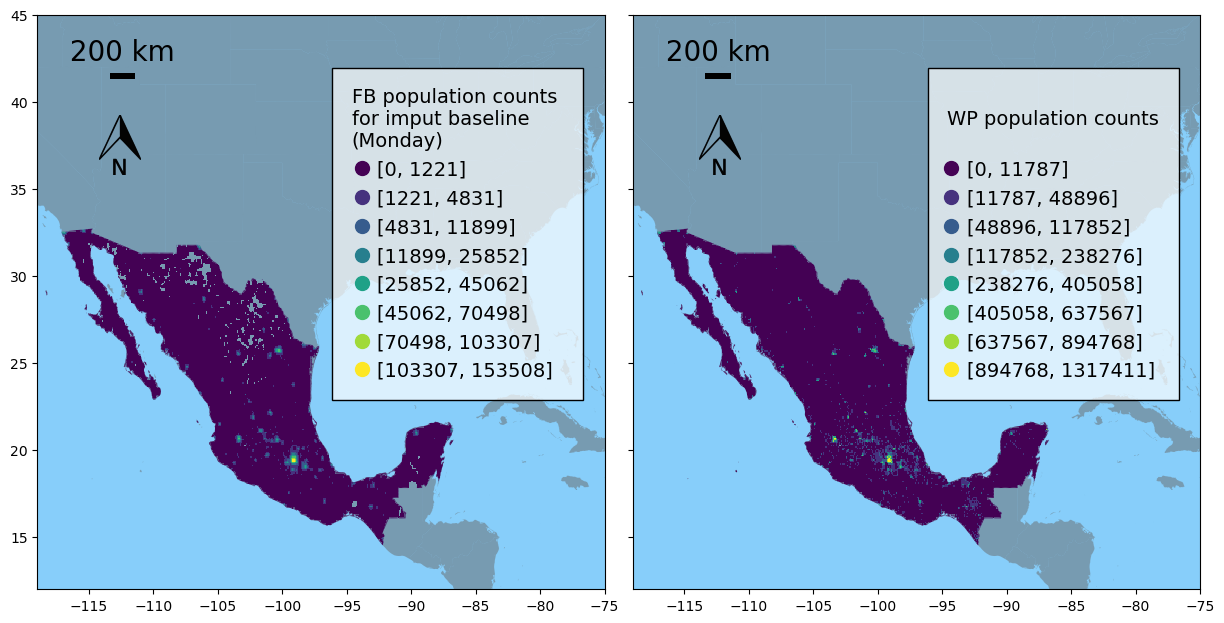

In [25]:
nrows=1
ncols=2
fig, (ax1, ax2) = plt.subplots(nrows= nrows, ncols = ncols, sharey=True, figsize = (15, 15))
fig.subplots_adjust(wspace=0.05)

grid_pop_imput_map = grid_pop_imput.dropna(subset=['pop_wp']).reset_index(drop=True)
grid_pop_imput_map = grid_pop_imput_map[grid_pop_imput_map['0']>0].reset_index(drop=True)
grid_pop_imput_map.plot(column='0', cmap='viridis', scheme='natural_breaks', k=8, legend=True, zorder=2, ax=ax1)

grid_pop.plot(column='pop_wp', cmap='viridis', scheme='natural_breaks', k=8, legend=True, zorder=2, ax=ax2)

if country != 'Mexico':
    background = gpd.read_file(wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp').to_crs('EPSG:4326')
else:
    background = gpd.read_file(wd + '/data/inputs/boundaries/central-america/bound_p.shp').to_crs('EPSG:4326')


for ax in (ax1, ax2):

    background.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)
    ax.set_facecolor('lightskyblue')
    
    if country == 'Argentina':
        ax.set_xlim(-75,-49)
        ax.set_ylim(-60,-19.5)
    elif country == 'Chile':
        ax.set_xlim(-80,-55)
        ax.set_ylim(-57,-16)
    elif country == 'Colombia':
        ax.set_xlim(-80,-53)
        ax.set_ylim(-5.5,17)
    elif country == 'Mexico':
        ax.set_xlim(-119,-75)
        ax.set_ylim(12,45)
    
#     ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelleft=False, labelbottom=False)
    
    labels = [t.get_text() for t in ax.get_legend().get_texts()]

    upper = []
    for i in range(len(labels)):
        a = labels[i].split(',')[1]
        b=[]
        for e in a:
            if e.isdigit() or e=='.':
                b.append(e)
        upper.append(float(''.join(b)))
    upper[-1] = upper[-1]+0.005

    custom_labels = ['[0, ' + str(int(upper[0])) + ']']
    for i in range(len(upper)-1):
        custom_labels.append('[' + str(int(upper[i])) + ', ' + str(int(upper[i+1])) + ']')

    colors=mcp.gen_color(cmap='viridis',n=8)
    legend_elements = [Line2D([0], [0], lw=0, color=colors[i],
                              marker='o', markersize=10, label=custom_labels[i]) for i in range(len(colors))]
    if ax==ax1:
        title = "FB population counts \nfor imput baseline \n(Monday)"
    else:
        title = '\nWP population counts\n'
    
    if country == 'Argentina':
        loc=(0.51,0.07)
    elif country == 'Chile':
        loc=(0.51,0.17)
    elif country == 'Colombia':
        loc=(0.51,0.07)
    elif country == 'Mexico':
        loc=(0.52,0.33)
    legend = ax.legend(handles=legend_elements, handlelength=0, fontsize = 14, shadow=False,
                       fancybox= False, loc=loc, ncol=1, columnspacing=1.2, 
                       borderpad=1, title = title)
    for t in legend.get_texts():
        t.set_ha('right')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1)
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.7))
    legend.get_title().set_fontsize('14')
    
    ax.add_artist(ScaleBar(dx=1,units="km",dimension="si-length",length_fraction=.1, 
                       scale_formatter=lambda value, unit: f' {value * 100} km ', 
                       pad=0.7, sep=5, border_pad = 1, scale_loc='top', box_color='w', box_alpha=0, font_properties={'size':20}, location='upper left'))


    im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')
    
    
    if country == 'Argentina':
        loc_arr1 = [0.455,0.75,0.04,0.04]
        loc_arr2 = [0.855,0.75,0.04,0.04]
    elif country == 'Chile':
        loc_arr1 = [0.455,0.77,0.04,0.04]
        loc_arr2 = [0.855,0.77,0.04,0.04]
    elif country == 'Colombia':
        loc_arr1 = [0.455,0.61,0.04,0.04]
        loc_arr2 = [0.855,0.61,0.04,0.04]
    elif country == 'Mexico':
        loc_arr1 = [0.16, 0.58, 0.04, 0.04]
        loc_arr2 = [0.56, 0.58, 0.04, 0.04]
        
    newax = fig.add_axes(loc_arr1, zorder=1)
    newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
    newax.set_facecolor('None')
    plt.setp(newax.spines.values(), linewidth=0)
    newax.imshow(im)
    
    newax = fig.add_axes(loc_arr2, zorder=1)
    newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
    newax.set_facecolor('None')
    plt.setp(newax.spines.values(), linewidth=0)
    newax.imshow(im)

In [27]:
grid_pop_map_w = grid_pop_imput_map.copy()

missing = []
for i in range(len(grid_pop_map_w)):
    if grid_pop_map_w.loc[i, '0'] > 1:
        missing.append(0)
    else:
        missing.append(1)

grid_pop_map_w['missing'] = missing 

grid_pop_map_w

missing_w = weights.Queen.from_dataframe(grid_pop_map_w, idVariable="FID")
grid_pop_map_w = grid_pop_map_w.drop(missing_w.islands)
missing_w = weights.Queen.from_dataframe(grid_pop_map_w, idVariable="FID")
missing_w.transform = 'R'

grid_pop_map_w['missing_w'] = weights.lag_spatial(missing_w, grid_pop_map_w['missing'])

jc = esda.join_counts.Join_Counts(grid_pop_map_w['missing'], missing_w)

print(jc.bb, jc.mean_bb, jc.p_sim_bb)

print(jc.ww)

print(jc.bw,  jc.mean_bw, jc.p_sim_bw)

/var/folders/_n/krcxvsq92k7bdd1nfpk3_9c00000gn/T/ipykernel_52299/2128672153.py:14: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  missing_w = weights.Queen.from_dataframe(grid_pop_map_w, idVariable="FID")
/Users/carmen/anaconda3/envs/geo-env-new/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 3 islands with ids: 624, 19102, 22870.
  W.__init__(self, neighbors, ids=ids, **kw)
/var/folders/_n/krcxvsq92k7bdd1nfpk3_9c00000gn/T/ipykernel_52299/2128672153.py:16: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  missing_w = weights.Queen.from_dataframe(grid_pop_map_w, idVariable="FID")
/Users/carmen/anaconda3/envs/geo-env-new/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.

('WARNING: ', 624, ' is an island (no neighbors)')
('WARNING: ', 19102, ' is an island (no neighbors)')
('WARNING: ', 22870, ' is an island (no neighbors)')
16555.0 5842.266266266266 0.001
67298.0
11388.0 35486.392392392394 1.0


In [28]:
grid_pop_map_w
grid_pop_bbox = grid_pop_map_w[grid_pop_map_w['missing']==0].reset_index(drop=True)
grid_pop_bbox

[minx, miny, maxx, maxy] = grid_pop_bbox.total_bounds
bbox = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[Polygon([[minx, miny],[maxx, miny],[maxx, maxy],[minx, maxy],[minx, miny]])])
bbox = bbox.to_crs('EPSG:4326')




In [29]:
grid_pop_imput

,FID,geometry,0,1,2,3,4,5,6,pop_wp
0,0,"POLYGON ((-92.28516 14.60484, -92.28516 14.587...",1.789244,1.827987,1.831134,1.829704,1.828568,1.753881,1.675756,23.459784
1,1,"POLYGON ((-92.28516 14.60484, -92.19727 14.604...",185.126274,185.157403,185.903621,185.255030,185.864361,183.093071,176.590457,3269.556885
2,2,"POLYGON ((-92.19727 14.60484, -92.17801 14.604...",484.303790,494.790356,495.642133,495.255086,494.947562,474.731868,453.585327,6349.977539
3,3,"POLYGON ((-92.37305 14.68988, -92.37305 14.667...",37.874741,38.694838,38.761451,38.731182,38.707132,37.126174,35.472419,496.596893
4,4,"POLYGON ((-92.37305 14.68988, -92.28516 14.689...",111.135735,110.860484,111.077817,110.630554,109.784782,108.153335,111.867716,4041.785156
...,...,...,...,...,...,...,...,...,...,...
25926,25926,"POLYGON ((-115.04883 32.69486, -115.05241 32.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25927,25927,"POLYGON ((-114.96094 32.69486, -115.04883 32.6...",0.141261,0.144319,0.144568,0.144455,0.144365,0.138469,0.132301,1.852146
25928,25928,"POLYGON ((-114.87305 32.69486, -114.96094 32.6...",2.865770,2.927822,2.932862,2.930572,2.928752,2.809130,2.683999,37.574707
25929,25929,"POLYGON ((-114.78516 32.69486, -114.87305 32.6...",2.113655,2.159422,2.163139,2.161450,2.160108,2.071880,1.979590,27.713316


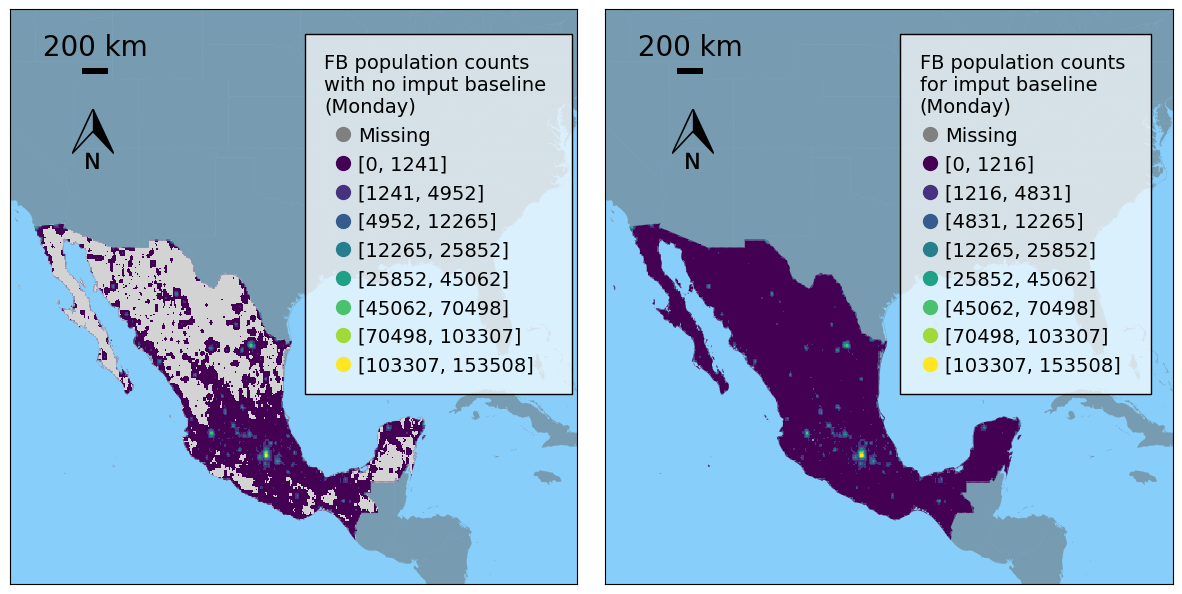

In [39]:
nrows=1
ncols=2
fig, (ax1, ax2) = plt.subplots(nrows= nrows, ncols = ncols, sharey=True, figsize = (15, 15))
fig.subplots_adjust(wspace=0.05)

grid_pop_imput_map = grid_pop_imput.dropna(subset=['pop_wp']).reset_index(drop=True)
# grid_pop_imput_map = grid_pop_imput_map[grid_pop_imput_map['0']>0].reset_index(drop=True)
grid_pop_imput_map.plot(column='0', cmap='viridis', scheme='natural_breaks', k=8, legend=True, zorder=2, ax=ax2)

grid_pop.plot(column='0', cmap='viridis', scheme='natural_breaks', k=8, legend=True, zorder=2, ax=ax1)

grid_pop_map_notmissing = grid_pop[grid_pop['0']> 0]
grid_pop_map_missing = grid_pop.drop(grid_pop_map_notmissing.index).reset_index(drop=True)

grid_pop_map_missing.plot(color='lightgray', zorder=3, ax=ax1)


if country != 'Mexico':
    background = gpd.read_file(wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp').to_crs('EPSG:4326')
else:
    background = gpd.read_file(wd + '/data/inputs/boundaries/central-america/bound_p.shp').to_crs('EPSG:4326')


for ax in (ax1, ax2):

    background.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)
    ax.set_facecolor('lightskyblue')
    
#     bbox.plot(ax=ax, fc='None', ec='red', lw=3, zorder=4)
    
    if country == 'Argentina':
        ax.set_xlim(-75,-49)
        ax.set_ylim(-60,-19.5)
    elif country == 'Chile':
        ax.set_xlim(-80,-55)
        ax.set_ylim(-57,-16)
    elif country == 'Colombia':
        ax.set_xlim(-80,-53)
        ax.set_ylim(-5.5,17)
    elif country == 'Mexico':
        ax.set_xlim(-119,-75)
        ax.set_ylim(12,45)
    
    ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelleft=False, labelbottom=False)
    
    labels = [t.get_text() for t in ax.get_legend().get_texts()]

    upper = []
    for i in range(len(labels)):
        a = labels[i].split(',')[1]
        b=[]
        for e in a:
            if e.isdigit() or e=='.':
                b.append(e)
        upper.append(float(''.join(b)))
    upper[-1] = upper[-1]+0.005

    custom_labels = list(['Missing'])
    custom_labels.append('[0, ' + str(int(upper[0])) + ']')
    for i in range(len(upper)-1):
        custom_labels.append('[' + str(int(upper[i])) + ', ' + str(int(upper[i+1])) + ']')

    colors=['gray'] + mcp.gen_color(cmap='viridis',n=8)
    legend_elements = [Line2D([0], [0], lw=0, color=colors[i],
                              marker='o', markersize=10, label= custom_labels[i]) for i in range(len(colors))]
    if ax==ax2:
        title = "FB population counts \nfor imput baseline \n(Monday)"
    else:
        title = 'FB population counts\nwith no imput baseline \n(Monday)'
        
    if country == 'Argentina':
        loc=(0.51,0.07)
    elif country == 'Chile':
        loc=(0.51,0.17)
    elif country == 'Colombia':
        loc=(0.51,0.07)
    elif country == 'Mexico':
        loc=(0.52,0.33)
    legend = ax.legend(handles=legend_elements, handlelength=0, fontsize = 14, shadow=False,
                       fancybox= False, loc=loc, ncol=1, columnspacing=1.2, 
                       borderpad=1, title = title)
    for t in legend.get_texts():
        t.set_ha('right')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1)
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.7))
    legend.get_title().set_fontsize('14')
    
    ax.add_artist(ScaleBar(dx=1,units="km",dimension="si-length",length_fraction=.1, 
                       scale_formatter=lambda value, unit: f' {value * 100} km ', 
                       pad=0.7, sep=5, border_pad = 1, scale_loc='top', box_color='w', box_alpha=0, font_properties={'size':20}, location='upper left'))


    im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')
    
    
    if country == 'Argentina':
        loc_arr1 = [0.455,0.75,0.04,0.04]
        loc_arr2 = [0.855,0.75,0.04,0.04]
    elif country == 'Chile':
        loc_arr1 = [0.455,0.77,0.04,0.04]
        loc_arr2 = [0.855,0.77,0.04,0.04]
    elif country == 'Colombia':
        loc_arr1 = [0.455,0.61,0.04,0.04]
        loc_arr2 = [0.855,0.61,0.04,0.04]
    elif country == 'Mexico':
        loc_arr1 = [0.16, 0.58, 0.04, 0.04]
        loc_arr2 = [0.56, 0.58, 0.04, 0.04]
        
    newax = fig.add_axes(loc_arr1, zorder=1)
    newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
    newax.set_facecolor('None')
    plt.setp(newax.spines.values(), linewidth=0)
    newax.imshow(im)
    
    newax = fig.add_axes(loc_arr2, zorder=1)
    newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
    newax.set_facecolor('None')
    plt.setp(newax.spines.values(), linewidth=0)
    newax.imshow(im)
    
plt.savefig(wd + '/plots/map-missing-fb-pop-baseline/map-missing-fb-pop-baseline-' + country_short + '.pdf', bbox_inches = 'tight')

plt.show()
